In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from threading import Thread 
from tqdm.notebook import tqdm
from datetime import datetime

In [2]:
X_train = np.load('X_train_surge.npz')
Y_train = pd.read_csv('Y_train_surge.csv')
X_test = np.load('X_test_surge_178mikI.npz')


In [8]:
for file in X_train.files:
    print(f"{file}: {X_train[file].shape}")

id_sequence: (5599,)
slp: (5599, 40, 41, 41)
t_slp: (5599, 40)
t_surge1_input: (5599, 10)
surge1_input: (5599, 10)
t_surge2_input: (5599, 10)
surge2_input: (5599, 10)
t_surge1_output: (5599, 10)
t_surge2_output: (5599, 10)


In [9]:
for file in X_test.files:
    print(f"{file}: {X_test[file].shape}")

id_sequence: (509,)
t_slp: (509, 40)
slp: (509, 40, 1681)
t_surge1_input: (509, 10)
surge1_input: (509, 10)
t_surge2_input: (509, 10)
surge2_input: (509, 10)
t_surge1_output: (509, 10)
t_surge2_output: (509, 10)


In [10]:
display(Y_train.head())

,id_sequence,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,...,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,1,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,...,-0.053886,0.356847,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057
1,2,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,...,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703
2,3,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,...,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733
3,4,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,...,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707
4,5,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,...,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707,-0.473001,-0.531677


# Arranging data

In [11]:
convert = np.vectorize(lambda x: datetime.fromtimestamp(int(x)).strftime("%b %d, %Y %I:%M:%S"))

In [12]:
print("Time of surge input")
print(convert(X_train["t_surge1_input"][0,:]))
print()
print("Time of surge output")
print(convert(X_train["t_surge1_output"][0,:]))
print()
print("Time of slp input")
print(convert(X_train["t_slp"][0,:]))
print()

Time of surge input
['Jan 01, 1950 01:00:00' 'Jan 02, 1950 01:00:00' 'Jan 02, 1950 01:59:44'
 'Jan 03, 1950 01:59:44' 'Jan 03, 1950 03:00:32' 'Jan 04, 1950 02:59:28'
 'Jan 04, 1950 03:00:32' 'Jan 05, 1950 02:59:28' 'Jan 05, 1950 04:00:16'
 'Jan 06, 1950 04:00:16']

Time of surge output
['Jan 06, 1950 05:00:00' 'Jan 07, 1950 05:00:00' 'Jan 07, 1950 05:00:00'
 'Jan 08, 1950 05:00:00' 'Jan 08, 1950 05:59:44' 'Jan 09, 1950 05:59:44'
 'Jan 09, 1950 05:59:44' 'Jan 10, 1950 07:00:32' 'Jan 10, 1950 06:59:28'
 'Jan 11, 1950 07:00:32']

Time of slp input
['Jan 01, 1950 09:59:44' 'Jan 02, 1950 01:00:00' 'Jan 02, 1950 04:00:16'
 'Jan 02, 1950 07:00:32' 'Jan 02, 1950 09:59:44' 'Jan 02, 1950 01:00:00'
 'Jan 02, 1950 04:00:16' 'Jan 02, 1950 06:59:28' 'Jan 02, 1950 09:59:44'
 'Jan 03, 1950 01:00:00' 'Jan 03, 1950 04:00:16' 'Jan 03, 1950 07:00:32'
 'Jan 03, 1950 09:59:44' 'Jan 03, 1950 01:00:00' 'Jan 03, 1950 04:00:16'
 'Jan 03, 1950 06:59:28' 'Jan 03, 1950 09:59:44' 'Jan 04, 1950 01:00:00'
 'Jan 04, 1

# Correlation

## With the SLP

Let's study the correlation between the slp and the surge for each location


In [3]:
corr1 = np.zeros((41, 41))
corr2 = np.zeros((41, 41))

surge1 = X_train["surge1_input"].reshape(-1)
surge2 = X_train["surge2_input"].reshape(-1)

def correlation(i, j, a):
    tmp_slp = X_train["slp"][:,[ind + a for ind in indexes],i,j].reshape(-1)
    corr1[i, j] += np.corrcoef(surge1, tmp_slp)[0,1]
    corr2[i, j] += np.corrcoef(surge2, tmp_slp)[0,1]

indexes = [t for t in range(40) if t%4==0 ]

for i in range(41):
    for j in range(41):
        t1 = Thread(target=correlation, args=(i, j, 0))
        t2 = Thread(target=correlation, args=(i, j, 1))
        t3 = Thread(target=correlation, args=(i, j, 2))
        t4 = Thread(target=correlation, args=(i, j, 3))
        t1.start()
        t2.start()
        t3.start()
        t4.start()
        t1.join()
        t2.join()
        t3.join()
        t4.join()
        
        corr1[i, j] /= 4
        corr2[i, j] /= 4
        
ax1 = sns.heatmap(corr1, cmap="RdYlGn")
ax1.set_title("Location 1")        

KeyboardInterrupt: 

In [ ]:
ax2= sns.heatmap(corr2, cmap="RdYlGn")
ax2.set_title("Location 2") 

## Between previous and future observations 

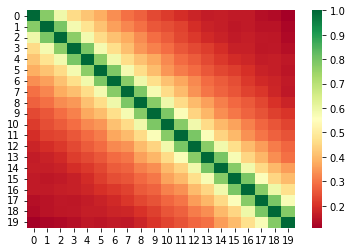

In [4]:
surge1_columns = [
    'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
    'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
ax = sns.heatmap(np.corrcoef(X_train["surge1_input"].T, Y_train[surge1_columns].T), cmap="RdYlGn")


# Plotting the surge

In [6]:
from scipy import interpolate
nb_plots = 8
indexes = np.random.randint(low=0, high=len(X_train["slp"])-1, size=nb_plots)
fig = plt.figure(figsize=(20,50))

for i in range(nb_plots):
    data = np.append(X_train["surge1_input"][indexes[i],:], Y_train.loc[indexes[i], surge1_columns])
    x_axis = np.append(X_train["t_surge1_input"][indexes[i],:], X_train["t_surge1_output"][indexes[i],:])
    f1 = interpolate.interp1d(x_axis, data,kind = 'quadratic')
    new_x = np.linspace(x_axis[0], x_axis[-1], 80)
    ax = fig.add_subplot(nb_plots, 1, i+1)
    ax.plot(x_axis, data, 'b--')
    ax.plot(new_x, f1(new_x), 'g-')

    ax.scatter(X_train["t_surge1_input"][indexes[i],:], X_train["surge1_input"][indexes[i],:], c='g', label='data')
    ax.scatter(X_train["t_surge1_output"][indexes[i],:], Y_train.loc[indexes[i], surge1_columns], c='r',label="to predict")
    ax.grid()

NameError: name 'surge1_columns' is not defined

<Figure size 1440x3600 with 0 Axes>

# PCA

For each SLP field, the input is of size $41*41=1681$, if we multiply by the 40 observations for each input the number of features is of 67240 which is quite large. Not only does this increase the risk of overfitting, but it also lengthen the computation. A way of reducing the dimension of the input is to apply the PCA algorithm to the input data. Let's first visualize a few of the slp fields

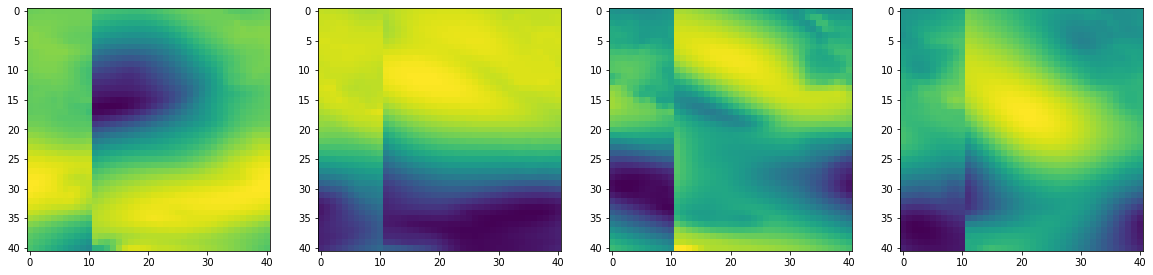

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 255))
slp_im = scaler.fit_transform(X_train["slp"].reshape(-1, 1)).reshape(-1, 40, 41, 41)

nb_plots = 4
fig = plt.figure(figsize=(20,15))

for i in range(nb_plots):
    ax = fig.add_subplot(1, nb_plots, i+1)
    plt.imshow(slp_im[indexes[i], np.random.randint(40), :,:])

## Number of components

The equations behind the PCA will not be explained here, however, a first step is to select the right number of components. If this number is too low, only a fraction of the information will be kept and the model will not be able to yield promising results. On the other hand, if it is too high more variance will be kept but the number of features will be higher, and most of them will only add a little bit of variance.

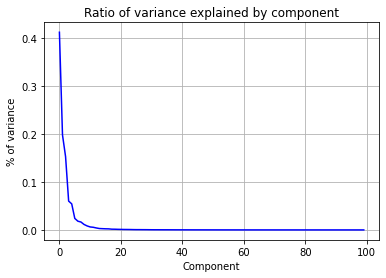

In [8]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=100)
pca.fit(X_train["slp"].reshape(len(X_train["slp"])*40,41*41))
variance = pca.explained_variance_ratio_

plt.figure()
plt.plot(variance, "b")
plt.title("Ratio of variance explained by component")
plt.ylabel("% of variance")
plt.xlabel("Component")
plt.grid()

After around 15 components, adding more of them does not increase much the variance, let's see the first few components

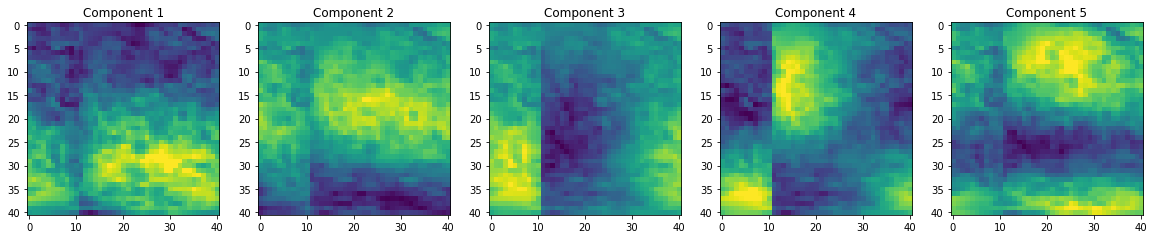

In [9]:
nb_plots = 5
fig = plt.figure(figsize=(20,15))
scaler_comp = MinMaxScaler(range(1,255))
comp = scaler_comp.fit_transform(pca.components_)

for i in range(nb_plots):
    ax = fig.add_subplot(1, nb_plots, i+1)
    plt.imshow(comp[i, :].reshape(41,41))
    plt.title(f"Component {i+1}")

# Input 2

In [5]:
import pickle

with open('new_X_train.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.keys())

dict_keys(['1', '2', 'id'])


In [10]:
print(data["1"].reshape(5599, -1, 41*41+1).shape)

(5599, 32, 1682)


# Histogram 

Text(0.5, 1.0, 'Surge distribution')

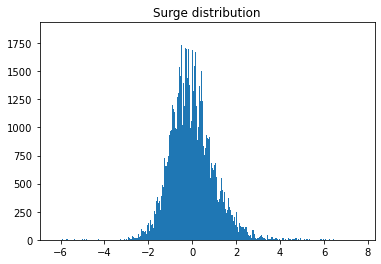

In [19]:
surge1_columns = [
    'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
    'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]

surge2_columns = [
    'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
    'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]

surge = np.concatenate((X_train["surge1_input"].flatten(), X_train["surge2_input"].flatten(),
                  X_test["surge1_input"].flatten(), X_test["surge2_input"].flatten(), 
                  Y_train[surge1_columns+surge2_columns].to_numpy().flatten()), axis=0)

plt.hist(surge, bins=1000)
plt.title("Surge distribution")